# BAX423 HW4
## Jiaqi Lu, Qihan Guan, Edwin Liu, Kexin Wang, Liqi Yi

## Import Data

In [1]:
import findspark
findspark.init('/home/jupyter/spark-3.1.1-bin-hadoop2.7') #code compiled in Google Cloud VM
import pandas as pd
import numpy as np
import pyspark
import pyspark.sql.functions as function
from pyspark import SparkConf, SparkContext
from pyspark.sql import Window
from pyspark.sql import SparkSession
from pyspark.sql.functions import expr
from pyspark.sql.functions import udf
from pyspark.sql.functions import *
from pyspark.sql.functions import count
from pyspark.sql.functions import concat
from pyspark.ml.feature import Tokenizer
from pyspark.sql.types import StringType, ArrayType, IntegerType, FloatType
import matplotlib.pyplot as plt
import emoji #pip install emoji
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [2]:
# Initialize spark session
spark = SparkSession\
        .builder\
        .appName('venmo')\
        .getOrCreate()

In [3]:
# Import Venmo data
venmo_df =spark.read.parquet('VenmoSample.snappy.parquet')
venmo_df.show(5)

+-------+-------+----------------+-------------------+------------+-----------+--------------------+
|  user1|  user2|transaction_type|           datetime| description|is_business|            story_id|
+-------+-------+----------------+-------------------+------------+-----------+--------------------+
|1218774|1528945|         payment|2015-11-27 10:48:19|        Uber|      false|5657c473cd03c9af2...|
|5109483|4782303|         payment|2015-06-17 11:37:04|      Costco|      false|5580f9702b64f70ab...|
|4322148|3392963|         payment|2015-06-19 07:05:31|Sweaty balls|      false|55835ccb1a624b14a...|
| 469894|1333620|          charge|2016-06-03 23:34:13|          🎥|      false|5751b185cd03c9af2...|
|2960727|3442373|         payment|2016-05-29 23:23:42|           ⚡|      false|574b178ecd03c9af2...|
+-------+-------+----------------+-------------------+------------+-----------+--------------------+
only showing top 5 rows



## Text Analytics

**Q0: Find 10 words that are not already in thedictionary and add them to it.**

We added words:   
       Food: cigarette. barbeque. pepper. 
       Event: repair. Cupping. Winter. 
       Utility: laptop. dogecoin 
       Illegal/Sarcasm: toxic. motherfucker.


**Q1: Use the text dictionary and the emoji dictionary to classify Venmo’s transactions in sample dataset.**

In [4]:
# Import the text and emoji dictionary with added new words
emoji = spark.read.option("header", True) \
    .csv("Venmo_Emoji_Classification_Dictionary.csv") \
    .withColumn("Cash", lit(None)) \
    .withColumn("Illegal/Sarcasm", lit(None))
emoji.show(5)
word = spark.read.option("header", True) \
    .csv('Venmo Word Classification Dictonary BAX-423 - Word_Dict.csv', header=True)
word.show(5)

# Merge the two dataset
dic = word.unionByName(emoji)
dic.show(5)

+-----+------+----+--------+--------------+------+-------+----+---------------+
|Event|Travel|Food|Activity|Transportation|People|Utility|Cash|Illegal/Sarcasm|
+-----+------+----+--------+--------------+------+-------+----+---------------+
| 🇦🇺|    🏔|  🍇|      👾|            🚄|    😀|      ⚡|null|           null|
| 🇫🇷|     ⛰|  🍈|      🕴|            🚅|    😃|     💡|null|           null|
|   🎂|    🌋|  🍉|      🎪|            🚆|    😄|     🔌|null|           null|
|   🛍|    🗻|  🍊|      🎭|            🚇|    😁|     📺|null|           null|
| 🇨🇦|    🏕|  🍋|      🎨|            🚈|    😆|     🔌|null|           null|
+-----+------+----+--------+--------------+------+-------+----+---------------+
only showing top 5 rows

+----------+---------+---------+--------+------+--------------+-----------+-----+---------------+
|    People|     Food|    Event|Activity|Travel|Transportation|    Utility| Cash|Illegal/Sarcasm|
+----------+---------+---------+--------+------+--------------+-----------+-----+--------------

In [5]:
# tokenize description
df_tokenized = Tokenizer(inputCol="description", outputCol="word_collection").transform(venmo_df)
df_tokenized.show(5)

+-------+-------+----------------+-------------------+------------+-----------+--------------------+---------------+
|  user1|  user2|transaction_type|           datetime| description|is_business|            story_id|word_collection|
+-------+-------+----------------+-------------------+------------+-----------+--------------------+---------------+
|1218774|1528945|         payment|2015-11-27 10:48:19|        Uber|      false|5657c473cd03c9af2...|         [uber]|
|5109483|4782303|         payment|2015-06-17 11:37:04|      Costco|      false|5580f9702b64f70ab...|       [costco]|
|4322148|3392963|         payment|2015-06-19 07:05:31|Sweaty balls|      false|55835ccb1a624b14a...|[sweaty, balls]|
| 469894|1333620|          charge|2016-06-03 23:34:13|          🎥|      false|5751b185cd03c9af2...|           [🎥]|
|2960727|3442373|         payment|2016-05-29 23:23:42|           ⚡|      false|574b178ecd03c9af2...|            [⚡]|
+-------+-------+----------------+-------------------+------------

In [6]:
# For each category, create lists for dictionary
people=[i[0] for i in dic.select(dic.columns[0]).collect()]
food=[i[0] for i in dic.select(dic.columns[1]).collect()]
event=[i[0] for i in dic.select(dic.columns[2]).collect()]
activity=[i[0] for i in dic.select(dic.columns[3]).collect()]
travel=[i[0] for i in dic.select(dic.columns[4]).collect()]
transportation=[i[0] for i in dic.select(dic.columns[5]).collect()]
utility=[i[0] for i in dic.select(dic.columns[6]).collect()]
cash=[i[0] for i in dic.select(dic.columns[7]).collect()]
illegal=[i[0] for i in dic.select(dic.columns[8]).collect()]
# Define a function to classify the words
def word_category(x):
    word_cate = []
    for var in x:
        if var in people:
            word_cate.append('People')
        if var in food:
            word_cate.append('Food')
        if var in event:
            word_cate.append('Event')
        if var in activity:
            word_cate.append('Activity')
        if var in travel:
            word_cate.append('Travel')
        if var in transportation:
            word_cate.append('Transportation')
        if var in utility:
            word_cate.append('Utility')
        if var in cash:
            word_cate.append('Cash')
        if var in illegal:
            word_cate.append('Illegal-Sarcasm')
    
    if len(word_cate)==0:
            word_cate.append('Other')
    return word_cate
# Define a function to classify each transaction's category
word_categorizer=function.udf(lambda x: word_category(x), ArrayType(StringType()))

In [7]:
df_tokenized = df_tokenized.withColumn('category',word_categorizer(function.col('word_collection')))
df_tokenized.show(20)

+--------+-------+----------------+-------------------+--------------------+-----------+--------------------+--------------------+--------------------+
|   user1|  user2|transaction_type|           datetime|         description|is_business|            story_id|     word_collection|            category|
+--------+-------+----------------+-------------------+--------------------+-----------+--------------------+--------------------+--------------------+
| 1218774|1528945|         payment|2015-11-27 10:48:19|                Uber|      false|5657c473cd03c9af2...|              [uber]|    [Transportation]|
| 5109483|4782303|         payment|2015-06-17 11:37:04|              Costco|      false|5580f9702b64f70ab...|            [costco]|              [Food]|
| 4322148|3392963|         payment|2015-06-19 07:05:31|        Sweaty balls|      false|55835ccb1a624b14a...|     [sweaty, balls]|   [Illegal-Sarcasm]|
|  469894|1333620|          charge|2016-06-03 23:34:13|                  🎥|      false|5

**Q2: What is the percent of emoji only transactions? Which are the top 5 most popular emoji? Which are the top three most popular emoji categories?**



**Percent of emoji only transactions**

In [10]:
# define a funciton for creating a emoji identifier column
import emoji
def is_emoji(x):
    result = []
    for val in x:
        if val in emoji.UNICODE_EMOJI_ENGLISH:
            result.append(val)
    return result

def not_emoji(x):
    result2 = []
    for val in x:
        if val not in emoji.UNICODE_EMOJI_ENGLISH:
            result2.append(val)
    return result2

emoji_filter = function.udf(lambda x: is_emoji(x), ArrayType(StringType()))
word_filter = function.udf(lambda x: not_emoji(x), ArrayType(StringType()))

In [11]:
description=df_tokenized.select('user1','user2','datetime', emoji_filter('word_collection').alias('emojis'),word_filter('word_collection').alias('words'))

In [12]:
description.show(5)

+-------+-------+-------------------+------+---------------+
|  user1|  user2|           datetime|emojis|          words|
+-------+-------+-------------------+------+---------------+
|1218774|1528945|2015-11-27 10:48:19|    []|         [uber]|
|5109483|4782303|2015-06-17 11:37:04|    []|       [costco]|
|4322148|3392963|2015-06-19 07:05:31|    []|[sweaty, balls]|
| 469894|1333620|2016-06-03 23:34:13|  [🎥]|             []|
|2960727|3442373|2016-05-29 23:23:42|   [⚡]|             []|
+-------+-------+-------------------+------+---------------+
only showing top 5 rows



In [13]:
# Check whether the word list is empty. If it's empty return 1 indicating there are only emojis
check = lambda x: 0 if len(x) > 0 else 1
emoji_only_checker = function.udf(lambda words:check(words),IntegerType())
emoji_only = description.select('user1','user2','datetime','emojis','words', emoji_only_checker('words').alias('is_emoji_only'))

In [14]:
emoji_only_num = emoji_only.where('is_emoji_only=1').count()
total = emoji_only.count()

In [15]:
print('Percent of emoji only transactions: ', emoji_only_num/total*100, '%')

Percent of emoji only transactions:  14.445342469855424 %


**Top 5 emojis**

In [16]:
emoji_count = description.select('emojis')
emoji_count.createOrReplaceTempView('emojis_count')
# Find the top 5 popolar emojis
spark.sql('''select emojis, count(emojis) from emojis_count 
              where emojis is not null and cardinality(emojis) <> 0
              group by emojis 
              order by count(emojis) desc''').show(5)

+------+-------------+
|emojis|count(emojis)|
+------+-------------+
|  [🍕]|        55226|
|  [🍻]|        43113|
|  [🍴]|        34173|
|  [🍺]|        28163|
|   [⛽]|        23596|
+------+-------------+
only showing top 5 rows



**Top 3 category**

In [17]:
# Use the categorize function again to find the category for emojis
emoji_cate=emoji_count.withColumn('category', word_categorizer(function.col('emojis')))

In [18]:
# Find the top 3 category with emojis
# Remove the is with empty category
emoji_cate=emoji_cate.filter(col('category')[0] != 'Other') # function.size can be used to see the length of column
emoji_cate.createOrReplaceTempView('emoji_category')
spark.sql('''select category, count(category) 
               from emoji_category
               group by category 
               order by count(category) desc''').show(3)

+----------+---------------+
|  category|count(category)|
+----------+---------------+
|    [Food]|         409599|
|  [People]|         274526|
|[Activity]|         108233|
+----------+---------------+
only showing top 3 rows



The percent of emoji only transactions is 14.4%.

The top 5 most popular emoji are: 🍕 🍻 🍴 🍺 ⛽

The top three most popular emoji categories are: Food, People, and Activity.


**Q3: For each user, create a variable to indicate their spending behavior profile. For
example, if a user has made 10 transactions, where 5 of them are food and the other 5 are
activity, then the user’s spending profile will be 50% food and 50% activity.**

In [19]:
user_profile= df_tokenized.select('user1','user2','category')
# Remove entries with no category 
user_profile=user_profile.filter(function.size('category')>0)
# Order by the user id and category
user_profile.createOrReplaceTempView('users')
user_spending_profile=spark.sql('''select * from users order by user1,category''')

In [20]:
user1_spending_profile=user_spending_profile.select('user1', function.explode('category').alias("category")).groupBy('user1','category').count()\
                                       .select('user1','category', 'count', function.sum('count').over(Window.partitionBy("user1").rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)).alias('total_count'))\
                                       .sort('user1', 'category')
# Calculate the proprotion of each category
user1_spending_profile=user1_spending_profile.select('user1','category', bround(100*col("count")/col("total_count")).alias("percentage"))

In [21]:
# Pivot the table
user1_spending_profile=user1_spending_profile.groupBy("user1").pivot("category").sum("percentage").sort("user1")
user1_spending_profile.show()

+-----+--------+----+-----+----+---------------+-----+------+--------------+------+-------+
|user1|Activity|Cash|Event|Food|Illegal-Sarcasm|Other|People|Transportation|Travel|Utility|
+-----+--------+----+-----+----+---------------+-----+------+--------------+------+-------+
|    2|    null|null| null|null|           null|100.0|  null|          null|  null|   null|
|    3|    null|null| null|17.0|           null| 50.0|  17.0|          null|  null|   17.0|
|    4|    25.0|null| null|25.0|           12.0| 25.0|  null|          null|  12.0|   null|
|   10|     7.0|null| null|43.0|           null| 29.0|  14.0|           7.0|  null|   null|
|   11|     7.0|null| 11.0|11.0|           null| 52.0|  11.0|          null|   4.0|    4.0|
|   12|    20.0|null| 10.0|10.0|           null| 40.0|  null|          null|  null|   20.0|
|   13|    12.0|null|  9.0|18.0|            3.0| 15.0|  24.0|           9.0|   3.0|    9.0|
|   16|    10.0|null| null|60.0|           null| 20.0|  null|          null|  10

**Q4: In the previous question, you got a static spending profile. However, life and social
networks are evolving over time. Therefore, let’s explore how a user’s spending profile is
evolving over her lifetime in Venmo. First of all, you need to analyze a user’s transactions in
monthly intervals, starting from 0 (indicating their first transaction only ) up to 12.**

In [22]:
spending_profile = df_tokenized.select('user1','user2','datetime', 'category')

In [23]:
spending_profile.show(5)

+-------+-------+-------------------+-----------------+
|  user1|  user2|           datetime|         category|
+-------+-------+-------------------+-----------------+
|1218774|1528945|2015-11-27 10:48:19| [Transportation]|
|5109483|4782303|2015-06-17 11:37:04|           [Food]|
|4322148|3392963|2015-06-19 07:05:31|[Illegal-Sarcasm]|
| 469894|1333620|2016-06-03 23:34:13|          [Event]|
|2960727|3442373|2016-05-29 23:23:42|        [Utility]|
+-------+-------+-------------------+-----------------+
only showing top 5 rows



In [24]:
# Create a dynamic profile
# extract month from date time
spending_profile.createOrReplaceTempView('spending_profile')
user_profile_dynamic=spark.sql('''select user1,
                                  CAST(MONTHS_BETWEEN(datetime, FIRST_VALUE(datetime) OVER (PARTITION BY user1 ORDER BY datetime)) as INT) as month,
                                  category
                                  from spending_profile''')
# filter for up to 12 month
user_profile_dynamic=user_profile_dynamic.filter(col('month') <= 12).sort('month')

In [25]:
user_profile_dynamic.show(5)

+-----+-----+------------+
|user1|month|    category|
+-----+-----+------------+
|  830|    0|   [Utility]|
|43443|    0|     [Other]|
|44379|    0|     [Other]|
|44964|    0|     [Other]|
|45016|    0|[Food, Food]|
+-----+-----+------------+
only showing top 5 rows



In [26]:
# unstack the category and calcualte the percentage 
user_profile_dynamic=user_profile_dynamic.select('user1','month', function.explode('category').alias("category")).groupBy('user1','month','category')\
                                  .count().select('user1','month','category','count', function.sum('count').over(Window.partitionBy("user1",'month')).alias('total_count'))\
                                  .sort('user1', 'month','category')
# calculate the percentage
user_profile_dynamic=user_profile_dynamic.select("user1","month",'category','count','total_count', bround(100*col("count")/col("total_count")).alias("percentage"))
user_profile_dynamic=user_profile_dynamic.select("user1","month",'category',"percentage")

In [27]:
# Pivot the table
summary_user_profile = user_profile_dynamic.groupBy('user1','month').pivot("category").sum("percentage").sort("user1",'month')

In [28]:
# Repalce null with 0
summary_user_profile.createOrReplaceTempView("summary_profile")
summary_user_profile = spark.sql('''
select user1, month,
       coalesce(`Activity`, 0) AS Activity,
       coalesce(`Cash`, 0) AS Cash,
       coalesce(`Event`, 0) AS Event,
       coalesce(`Food`, 0) AS Food,
       coalesce(`Illegal-Sarcasm`, 0) AS `Illegal-Sarcasm`,
       coalesce(`Other`, 0) AS Other,
       coalesce(`People`, 0) AS People,
       coalesce(`Transportation`, 0) AS Transportation,
       coalesce(`Travel`, 0) AS Travel,
       coalesce(`Utility`, 0) AS Utility
from summary_profile 
order by user1, month
''')

In [29]:
summary_user_profile.show(20)

+-----+-----+--------+----+-----+-----+---------------+-----+------+--------------+------+-------+
|user1|month|Activity|Cash|Event| Food|Illegal-Sarcasm|Other|People|Transportation|Travel|Utility|
+-----+-----+--------+----+-----+-----+---------------+-----+------+--------------+------+-------+
|    2|    0|     0.0| 0.0|  0.0|  0.0|            0.0|100.0|   0.0|           0.0|   0.0|    0.0|
|    3|    0|     0.0| 0.0|  0.0| 17.0|            0.0| 50.0|  17.0|           0.0|   0.0|   17.0|
|    4|    0|     0.0| 0.0|  0.0| 67.0|           33.0|  0.0|   0.0|           0.0|   0.0|    0.0|
|   10|    0|     0.0| 0.0|  0.0| 50.0|            0.0|  0.0|  50.0|           0.0|   0.0|    0.0|
|   10|    1|    50.0| 0.0|  0.0|  0.0|            0.0| 50.0|   0.0|           0.0|   0.0|    0.0|
|   10|    3|     0.0| 0.0|  0.0| 50.0|            0.0|  0.0|  50.0|           0.0|   0.0|    0.0|
|   10|    4|     0.0| 0.0|  0.0|  0.0|            0.0|100.0|   0.0|           0.0|   0.0|    0.0|
|   11|   

**Q5: Write a script to find a user’s friends and friends of friends (Friend definition:Auser’s friend is someone who has transacted with theuser, either sending money to the user orreceiving money from the user).**

In [95]:
# return the direct firends of each user
def first_degree_friends(user_id):
    user1=venmo_df.select("user1","user2").where("user1=={}".format(user_id))
    user2=venmo_df.select("user2","user1").where("user2=={}".format(user_id))
    friends=user1.union(user2).distinct().sort("user2").select("user2")
    return friends

In [99]:
# display direct friends of user_id, for example, user_id = 3.
first_degree_friends(2).show()

+------+
| user2|
+------+
|    43|
|   220|
|191142|
+------+



In [97]:
# return second degree friends
def find_friends_of_friends():
    friends_new=spark.sql("WITH t AS \
    (SELECT DISTINCT user1,user2 FROM ((SELECT user1, user2 FROM parquet) UNION (SELECT user2,user1 FROM parquet) ))\
    SELECT DISTINCT t1.user1 AS user1,t2.user2 AS 2nd_degree_friends\
    FROM t t1 LEFT JOIN t t2 on t1.user2=t2.user1 AND t1.user1 !=t2.user2\
    WHERE t2.user2 IS NOT NULL and t2.user2 NOT IN (SELECT t3.user2 FROM t t3 WHERE t3.user1=t1.user1)\
    ORDER BY user1,2nd_degree_friends")
    return friends_new

In [98]:
find_friends_of_friends().show()

+-----+------------------+
|user1|2nd_degree_friends|
+-----+------------------+
|    2|                 3|
|    2|                10|
|    2|                19|
|    2|                96|
|    2|               629|
|    2|              3565|
|    2|             20530|
|    2|             20639|
|    2|             47104|
|    2|             49778|
|    2|             55895|
|    2|             72106|
|    2|             82697|
|    2|            183628|
|    2|            276439|
|    2|            297967|
|    2|            307603|
|    2|            316862|
|    2|            613769|
|    2|            851628|
+-----+------------------+
only showing top 20 rows



**Q6: Calculate social network metrics**

q6i - Number of friends and number of friends of friends

In [218]:
# Calculate the number of days passed wince the user's first transaction
assign_month = function.udf(lambda x: 0 if (x == 0) else math.ceil(x/30))

In [219]:
# Merge
friend_to = venmo_df.select('user1', 'user2', 'datetime')
friend_from = venmo_df.select('user2', 'user1', 'datetime')
friend_all = friend_to.union(friend_from)
friend_all.show(5)

+-------+-------+-------------------+
|  user1|  user2|           datetime|
+-------+-------+-------------------+
|1218774|1528945|2015-11-27 10:48:19|
|5109483|4782303|2015-06-17 11:37:04|
|4322148|3392963|2015-06-19 07:05:31|
| 469894|1333620|2016-06-03 23:34:13|
|2960727|3442373|2016-05-29 23:23:42|
+-------+-------+-------------------+
only showing top 5 rows



In [220]:
# assign a 'month' to user1 and user2

w1 = Window.partitionBy('user1')
friend_all_days = friend_all.withColumn("days", function.datediff("datetime", function.min("datetime").over(w1)))
group_user1 = friend_all_days.withColumn('month', assign_month(function.col('days')))
group_user1 = group_user1.withColumn("month", group_user1["month"].cast(IntegerType()))

w2 = Window.partitionBy('user2')
group_user2 = group_user1.withColumn("days2", function.datediff("datetime", function.min("datetime").over(w2)))
group_month = group_user2.withColumn('month2', assign_month(function.col('days2')))
group_month = group_month.withColumn("month2", group_month["month2"].cast(IntegerType()))

group_month.createOrReplaceTempView("group_month")

In [221]:
total_friend = spark.sql("""SELECT user1, month, COUNT(DISTINCT user2) AS FRIEND_NUM
                        FROM group_month t1 
                        WHERE month <= 12
                        GROUP BY user1, month
                        ORDER BY user1, month""")
total_friend.createOrReplaceTempView("total_friend")

In [222]:
# attach number of friends' of user2 to the table

num_friends_user2 = spark.sql("""SELECT t1.*, t2.friend_num
                        FROM group_month t1
                            INNER JOIN total_friend t2 
                                ON t1.user2 = t2.user1
                                AND t1.month2 = t2.month
                        ORDER BY user1, user2""")
num_friends_user2.createOrReplaceTempView("num_friends_user2")

In [223]:
# Select only distinct user2 (user1's friends) and less than 12 months

num_fof_month = spark.sql("""SELECT DISTINCT user1, month, user2, friend_num
                            FROM num_friends_user2
                            WHERE month <= 12
                            ORDER BY user1, month""")
num_fof_month.createOrReplaceTempView("num_fof_month")

In [224]:
# join the result

num_fof_month2 = spark.sql("""SELECT t1.user1, t1.month, IFNULL(SUM(t2.friend_num), 0) AS fof_num
                        FROM total_friend t1
                            LEFT JOIN num_fof_month t2
                            ON t1.user1 = t2.user1
                            AND t1.month = t2.month
                        WHERE t1.month <= 12
                        GROUP BY t1.user1, t1.month
                        ORDER BY t1.user1, t1.month""")
num_fof_month2.createOrReplaceTempView("num_fof_month2")

In [225]:
## Combine the number of direct friends and friends' friends
num_f_fof = spark.sql("""SELECT t1.user1, t1.month, t1.friend_num, t2.fof_num
                        FROM total_friend t1 
                            LEFT JOIN num_fof_month2 t2
                            ON t1.user1 = t2.user1
                            AND t1.month = t2.month
                        WHERE t1.month <= 12
                        ORDER BY t1.user1, t1.month""")
num_f_fof.createOrReplaceTempView("num_f_fof")

In [226]:
# Number of friends and number of friends of friends table
num_f_fof.show()

+-----+-----+----------+-------+
|user1|month|friend_num|fof_num|
+-----+-----+----------+-------+
|    2|    0|         1|      1|
|    3|    0|         1|      0|
|    3|    1|         1|      0|
|    3|    3|         1|      0|
|    3|    4|         4|      3|
|    3|    5|         1|      0|
|    4|    0|         1|      1|
|    4|    1|         1|      1|
|    4|    2|         1|      1|
|    6|    0|         1|      1|
|    6|   10|         1|      1|
|    8|    0|         1|      1|
|    8|    2|         1|      2|
|    8|    7|         2|      2|
|    8|    9|         1|      1|
|    8|   10|         1|      2|
|    9|    0|         1|      1|
|    9|    2|         1|      1|
|    9|    5|         1|      1|
|    9|    7|         1|      1|
+-----+-----+----------+-------+
only showing top 20 rows



q6ii - Clustering coefficient of a user's network

In [227]:
# Calculate possible triplets

triplet_pos = spark.sql("""
                        SELECT user1, month, 
                            CASE 
                                WHEN friend_num <= 1 THEN 0 
                                ELSE INT(friend_num * (friend_num -1)/2)
                                END AS tri_pos 
                        FROM total_friend 
                        WHERE month <= 12
                        ORDER BY 1,2""")
triplet_pos.createOrReplaceTempView("triplet_pos")

In [228]:
# Calculate existed triplets

tri_actual = spark.sql("""
                        SELECT t1.user1, t1.month, IFNULL(COUNT(DISTINCT *), 0) AS tri_act
                        FROM group_month t1
                            INNER JOIN group_month t2
                                ON t1.month <= 12
                                AND t1.user2 = t2.user1
                            LEFT JOIN (SELECT DISTINCT t3.user1, t3.month, t3.user2
                                        FROM group_month t3
                                        WHERE t3.month <= 12
                                        ) t3
                                ON t3.user2 = t2.user2
                                AND t3.user1 = t1.user1
                                AND t3.month = t1.month
                        GROUP BY t1.user1, t1.month
                        ORDER BY t1.user1, t1.month""")
tri_actual.createOrReplaceTempView("tri_actual")

In [229]:
# Calculate clustering coefficients

cluster = spark.sql("""
                        SELECT t1.user1, t1.month, IFNULL(tri_act/tri_pos, 0) AS cluster_coef
                        FROM triplet_pos t2
                        LEFT JOIN tri_actual t1
                        ON t1.user1 = t2.user1
                        AND t1.month = t2.month
                        ORDER BY t1.user1, t1.month""")
cluster.createOrReplaceTempView("cluster")

In [230]:
cluster.show()


+-----+-----+------------+
|user1|month|cluster_coef|
+-----+-----+------------+
|    2|    0|         0.0|
|    3|    0|         0.0|
|    3|    1|         0.0|
|    3|    3|         0.0|
|    3|    4|         0.0|
|    3|    5|         0.0|
|    4|    0|         0.0|
|    4|    1|         0.0|
|    4|    2|         0.0|
|    6|    0|         0.0|
|    6|   10|         0.0|
|    8|    0|         0.0|
|    8|    2|         0.0|
|    8|    7|         0.0|
|    8|    9|         0.0|
|    8|   10|         0.0|
|    9|    0|         0.0|
|    9|    2|         0.0|
|    9|    5|         0.0|
|    9|    7|         0.0|
+-----+-----+------------+
only showing top 20 rows



6iii- Calculate the page rank of each user

In [231]:
from pyspark import SparkContext, SparkConf
#from graphframes.examples import Graphs
from pyspark.sql import Window
from pyspark.sql.functions import monotonically_increasing_id 
from graphframes import GraphFrame
from pyspark.sql.functions import *

In [232]:
#create vertices table
user1=venmo_df.select("user1")
user2=venmo_df.select("user2")
user_id=user1.union(user2).distinct()
vertices=user_id.withColumnRenamed('user1',"id")

In [233]:
#create edges table
edges=venmo_df.select("user1","user2","transaction_type").withColumnRenamed('user1','src').withColumnRenamed('user2','dst')


In [ ]:
#GraphFrame -- Error -- Output ommitted beacuaes graphframe was not working with spark
g = GraphFrame(vertices, edges)
display(g)

In [ ]:
#Display graphframe results -- Unable to display 
results = g.pageRank(resetProbability=0.15, maxIter=1)
display(results.vertices)

# Predictive Analytics with MLlib

**Q7: First, create your dependent variableY,i.e. the total number of transactions at lifetimepoint 12. In other words, for every user, you needto count how many transactions s/he hadcommitted during her/his twelve months in Venmo.**

In [17]:
user1 = venmo_df.select("user1", "datetime").withColumnRenamed('user1', 'users')
user2 = venmo_df.select("user2", "datetime").withColumnRenamed('user2', 'users')
user_all = user1.union(user2).orderBy("users")

In [18]:
user_all = user_all.withColumn('timestamp', function.unix_timestamp('datetime', 'yyyy-MM-dd'))
num_12 = user_all.withColumn('num_12_month', function.count('users').over(Window.partitionBy('users').orderBy('timestamp').rangeBetween(0, 365*86400))).orderBy('users', 'datetime')

In [20]:
Y = num_12.withColumn("earliest", function.min("datetime").over(Window.partitionBy("users"))).where(col("datetime") == col("earliest")).drop("earliest").orderBy("users")
Y = Y.select('users', 'num_12_month')
Y.show(20)

+-----+------------+
|users|num_12_month|
+-----+------------+
|    2|           1|
|    3|           9|
|    4|           4|
|    6|           2|
|    8|           6|
|    9|           5|
|   10|          12|
|   11|          13|
|   12|           5|
|   13|           5|
|   16|           7|
|   18|           1|
|   19|           2|
|   24|           2|
|   28|           2|
|   29|           2|
|   31|           1|
|   32|           1|
|   34|           5|
|   42|           5|
+-----+------------+
only showing top 20 rows



**Q8: Create the recency and frequency variables.**

In [21]:
def q8_for_life_0():
    df = spark.sql("SELECT *, add_months(min(datetime) over (partition by users), 0) AS end_date FROM user_all").createOrReplaceTempView("df")
    df = spark.sql("SELECT *FROM df WHERE datetime <= end_date").createOrReplaceTempView("df")
    df = spark.sql("SELECT *, datediff(end_date, datetime) as diff FROM df").createOrReplaceTempView("df")
    df = spark.sql("SELECT *, max(diff) over (partition by users order by datetime) + 0 as diff_first_trans FROM df").createOrReplaceTempView("df")
    df = spark.sql("SELECT *, row_number() over(partition by users order by datetime) trans_num FROM df").createOrReplaceTempView("df")
    df = spark.sql("SELECT users, MIN(diff) AS recency, ROUND(MAX(trans_num)/MAX(diff_first_trans),4) AS frequency FROM df GROUP BY users")
    return df

def q8_for_life_1():
    df = spark.sql("SELECT *, add_months(min(datetime) over (partition by users), 1) AS end_date FROM user_all").createOrReplaceTempView("df")
    df = spark.sql("SELECT *FROM df WHERE datetime <= end_date").createOrReplaceTempView("df")
    df = spark.sql("SELECT *, datediff(end_date, datetime) as diff FROM df").createOrReplaceTempView("df")
    df = spark.sql("SELECT *, max(diff) over (partition by users order by datetime) + 1 as diff_first_trans FROM df").createOrReplaceTempView("df")
    df = spark.sql("SELECT *, row_number() over(partition by users order by datetime) trans_num FROM df").createOrReplaceTempView("df")
    df = spark.sql("SELECT users, MIN(diff) AS recency, ROUND(MAX(trans_num)/MAX(diff_first_trans),4) AS frequency FROM df GROUP BY users")
    return df

def q8_for_life_2():
    df = spark.sql("SELECT *, add_months(min(datetime) over (partition by users), 2) AS end_date FROM user_all").createOrReplaceTempView("df")
    df = spark.sql("SELECT *FROM df WHERE datetime <= end_date").createOrReplaceTempView("df")
    df = spark.sql("SELECT *, datediff(end_date, datetime) as diff FROM df").createOrReplaceTempView("df")
    df = spark.sql("SELECT *, max(diff) over (partition by users order by datetime) + 2 as diff_first_trans FROM df").createOrReplaceTempView("df")
    df = spark.sql("SELECT *, row_number() over(partition by users order by datetime) trans_num FROM df").createOrReplaceTempView("df")
    df = spark.sql("SELECT users, MIN(diff) AS recency, ROUND(MAX(trans_num)/MAX(diff_first_trans),4) AS frequency FROM df GROUP BY users")
    return df

def q8_for_life_3():
    df = spark.sql("SELECT *, add_months(min(datetime) over (partition by users), 3) AS end_date FROM user_all").createOrReplaceTempView("df")
    df = spark.sql("SELECT *FROM df WHERE datetime <= end_date").createOrReplaceTempView("df")
    df = spark.sql("SELECT *, datediff(end_date, datetime) as diff FROM df").createOrReplaceTempView("df")
    df = spark.sql("SELECT *, max(diff) over (partition by users order by datetime) + 3 as diff_first_trans FROM df").createOrReplaceTempView("df")
    df = spark.sql("SELECT *, row_number() over(partition by users order by datetime) trans_num FROM df").createOrReplaceTempView("df")
    df = spark.sql("SELECT users, MIN(diff) AS recency, ROUND(MAX(trans_num)/MAX(diff_first_trans),4) AS frequency FROM df GROUP BY users")
    return df

def q8_for_life_4():
    df = spark.sql("SELECT *, add_months(min(datetime) over (partition by users), 4) AS end_date FROM user_all").createOrReplaceTempView("df")
    df = spark.sql("SELECT *FROM df WHERE datetime <= end_date").createOrReplaceTempView("df")
    df = spark.sql("SELECT *, datediff(end_date, datetime) as diff FROM df").createOrReplaceTempView("df")
    df = spark.sql("SELECT *, max(diff) over (partition by users order by datetime) + 4 as diff_first_trans FROM df").createOrReplaceTempView("df")
    df = spark.sql("SELECT *, row_number() over(partition by users order by datetime) trans_num FROM df").createOrReplaceTempView("df")
    df = spark.sql("SELECT users, MIN(diff) AS recency, ROUND(MAX(trans_num)/MAX(diff_first_trans),4) AS frequency FROM df GROUP BY users")
    return df

def q8_for_life_5():
    df = spark.sql("SELECT *, add_months(min(datetime) over (partition by users), 5) AS end_date FROM user_all").createOrReplaceTempView("df")
    df = spark.sql("SELECT *FROM df WHERE datetime <= end_date").createOrReplaceTempView("df")
    df = spark.sql("SELECT *, datediff(end_date, datetime) as diff FROM df").createOrReplaceTempView("df")
    df = spark.sql("SELECT *, max(diff) over (partition by users order by datetime) + 5 as diff_first_trans FROM df").createOrReplaceTempView("df")
    df = spark.sql("SELECT *, row_number() over(partition by users order by datetime) trans_num FROM df").createOrReplaceTempView("df")
    df = spark.sql("SELECT users, MIN(diff) AS recency, ROUND(MAX(trans_num)/MAX(diff_first_trans),4) AS frequency FROM df GROUP BY users")
    return df

def q8_for_life_6():
    df = spark.sql("SELECT *, add_months(min(datetime) over (partition by users), 6) AS end_date FROM user_all").createOrReplaceTempView("df")
    df = spark.sql("SELECT *FROM df WHERE datetime <= end_date").createOrReplaceTempView("df")
    df = spark.sql("SELECT *, datediff(end_date, datetime) as diff FROM df").createOrReplaceTempView("df")
    df = spark.sql("SELECT *, max(diff) over (partition by users order by datetime) + 6 as diff_first_trans FROM df").createOrReplaceTempView("df")
    df = spark.sql("SELECT *, row_number() over(partition by users order by datetime) trans_num FROM df").createOrReplaceTempView("df")
    df = spark.sql("SELECT users, MIN(diff) AS recency, ROUND(MAX(trans_num)/MAX(diff_first_trans),4) AS frequency FROM df GROUP BY users")
    return df

def q8_for_life_7():
    df = spark.sql("SELECT *, add_months(min(datetime) over (partition by users), 7) AS end_date FROM user_all").createOrReplaceTempView("df")
    df = spark.sql("SELECT *FROM df WHERE datetime <= end_date").createOrReplaceTempView("df")
    df = spark.sql("SELECT *, datediff(end_date, datetime) as diff FROM df").createOrReplaceTempView("df")
    df = spark.sql("SELECT *, max(diff) over (partition by users order by datetime) + 7 as diff_first_trans FROM df").createOrReplaceTempView("df")
    df = spark.sql("SELECT *, row_number() over(partition by users order by datetime) trans_num FROM df").createOrReplaceTempView("df")
    df = spark.sql("SELECT users, MIN(diff) AS recency, ROUND(MAX(trans_num)/MAX(diff_first_trans),4) AS frequency FROM df GROUP BY users")
    return df

def q8_for_life_8():
    df = spark.sql("SELECT *, add_months(min(datetime) over (partition by users), 8) AS end_date FROM user_all").createOrReplaceTempView("df")
    df = spark.sql("SELECT *FROM df WHERE datetime <= end_date").createOrReplaceTempView("df")
    df = spark.sql("SELECT *, datediff(end_date, datetime) as diff FROM df").createOrReplaceTempView("df")
    df = spark.sql("SELECT *, max(diff) over (partition by users order by datetime) + 8 as diff_first_trans FROM df").createOrReplaceTempView("df")
    df = spark.sql("SELECT *, row_number() over(partition by users order by datetime) trans_num FROM df").createOrReplaceTempView("df")
    df = spark.sql("SELECT users, MIN(diff) AS recency, ROUND(MAX(trans_num)/MAX(diff_first_trans),4) AS frequency FROM df GROUP BY users")
    return df

def q8_for_life_9():
    df = spark.sql("SELECT *, add_months(min(datetime) over (partition by users), 9) AS end_date FROM user_all").createOrReplaceTempView("df")
    df = spark.sql("SELECT *FROM df WHERE datetime <= end_date").createOrReplaceTempView("df")
    df = spark.sql("SELECT *, datediff(end_date, datetime) as diff FROM df").createOrReplaceTempView("df")
    df = spark.sql("SELECT *, max(diff) over (partition by users order by datetime) + 9 as diff_first_trans FROM df").createOrReplaceTempView("df")
    df = spark.sql("SELECT *, row_number() over(partition by users order by datetime) trans_num FROM df").createOrReplaceTempView("df")
    df = spark.sql("SELECT users, MIN(diff) AS recency, ROUND(MAX(trans_num)/MAX(diff_first_trans),4) AS frequency FROM df GROUP BY users")
    return df

def q8_for_life_10():
    df = spark.sql("SELECT *, add_months(min(datetime) over (partition by users), 10) AS end_date FROM user_all").createOrReplaceTempView("df")
    df = spark.sql("SELECT *FROM df WHERE datetime <= end_date").createOrReplaceTempView("df")
    df = spark.sql("SELECT *, datediff(end_date, datetime) as diff FROM df").createOrReplaceTempView("df")
    df = spark.sql("SELECT *, max(diff) over (partition by users order by datetime) + 10 as diff_first_trans FROM df").createOrReplaceTempView("df")
    df = spark.sql("SELECT *, row_number() over(partition by users order by datetime) trans_num FROM df").createOrReplaceTempView("df")
    df = spark.sql("SELECT users, MIN(diff) AS recency, ROUND(MAX(trans_num)/MAX(diff_first_trans),4) AS frequency FROM df GROUP BY users")
    return df

def q8_for_life_11():
    df = spark.sql("SELECT *, add_months(min(datetime) over (partition by users), 11) AS end_date FROM user_all").createOrReplaceTempView("df")
    df = spark.sql("SELECT *FROM df WHERE datetime <= end_date").createOrReplaceTempView("df")
    df = spark.sql("SELECT *, datediff(end_date, datetime) as diff FROM df").createOrReplaceTempView("df")
    df = spark.sql("SELECT *, max(diff) over (partition by users order by datetime) + 11 as diff_first_trans FROM df").createOrReplaceTempView("df")
    df = spark.sql("SELECT *, row_number() over(partition by users order by datetime) trans_num FROM df").createOrReplaceTempView("df")
    df = spark.sql("SELECT users, MIN(diff) AS recency, ROUND(MAX(trans_num)/MAX(diff_first_trans),4) AS frequency FROM df GROUP BY users")
    return df

def q8_for_life_12():
    df = spark.sql("SELECT *, add_months(min(datetime) over (partition by users), 12) AS end_date FROM user_all").createOrReplaceTempView("df")
    df = spark.sql("SELECT *FROM df WHERE datetime <= end_date").createOrReplaceTempView("df")
    df = spark.sql("SELECT *, datediff(end_date, datetime) as diff FROM df").createOrReplaceTempView("df")
    df = spark.sql("SELECT *, max(diff) over (partition by users order by datetime) + 12 as diff_first_trans FROM df").createOrReplaceTempView("df")
    df = spark.sql("SELECT *, row_number() over(partition by users order by datetime) trans_num FROM df").createOrReplaceTempView("df")
    df = spark.sql("SELECT users, MIN(diff) AS recency, ROUND(MAX(trans_num)/MAX(diff_first_trans),4) AS frequency FROM df GROUP BY users")
    return df

In [22]:
user_all_t=user_all.createOrReplaceTempView("user_all")

q8_for_life_0().show(10, False)
q8_for_life_1().show(10, False)
q8_for_life_2().show(10, False)
q8_for_life_3().show(10, False)
q8_for_life_4().show(10, False)
q8_for_life_5().show(10, False)
q8_for_life_6().show(10, False)
q8_for_life_7().show(10, False)
q8_for_life_8().show(10, False)
q8_for_life_9().show(10, False)
q8_for_life_10().show(10, False)
q8_for_life_11().show(10, False)
q8_for_life_12().show(10, False)

+-------+-------+---------+
|users  |recency|frequency|
+-------+-------+---------+
|93191  |0      |null     |
|507462 |0      |null     |
|507479 |0      |null     |
|516127 |0      |null     |
|576452 |0      |null     |
|810928 |0      |null     |
|899821 |0      |null     |
|944301 |0      |null     |
|1145935|0      |null     |
|1225172|0      |null     |
+-------+-------+---------+
only showing top 10 rows

+-----+-------+---------+
|users|recency|frequency|
+-----+-------+---------+
|2    |30     |0.0323   |
|3    |4      |0.0645   |
|4    |19     |0.0938   |
|6    |30     |0.0323   |
|8    |31     |0.0313   |
|9    |30     |0.0323   |
|10   |2      |0.0645   |
|11   |22     |0.0625   |
|12   |30     |0.0323   |
|13   |30     |0.0323   |
+-----+-------+---------+
only showing top 10 rows

+-----+-------+---------+
|users|recency|frequency|
+-----+-------+---------+
|2    |61     |0.0159   |
|3    |35     |0.0317   |
|4    |29     |0.0625   |
|6    |61     |0.0159   |
|8    |20 

In [23]:
rf_all = q8_for_life_1().union(q8_for_life_2())\
               .union(q8_for_life_3()).union(q8_for_life_4()).union(q8_for_life_5())\
               .union(q8_for_life_6()).union(q8_for_life_7()).union(q8_for_life_8())\
               .union(q8_for_life_9()).union(q8_for_life_10()).union(q8_for_life_11())\
               .union(q8_for_life_12())
rf_all.show(20)

+-----+-------+---------+
|users|recency|frequency|
+-----+-------+---------+
|    2|     30|   0.0323|
|    3|      4|   0.0645|
|    4|     19|   0.0938|
|    6|     30|   0.0323|
|    8|     31|   0.0313|
|    9|     30|   0.0323|
|   10|      2|   0.0645|
|   11|     22|   0.0625|
|   12|     30|   0.0323|
|   13|     30|   0.0323|
|   16|     23|   0.0625|
|   18|     29|   0.0333|
|   19|     23|   0.0625|
|   24|     31|   0.0313|
|   28|     20|   0.0625|
|   29|     30|   0.0323|
|   31|     31|   0.0313|
|   32|     30|   0.0323|
|   34|     31|   0.0313|
|   42|     31|   0.0313|
+-----+-------+---------+
only showing top 20 rows



In [26]:
rf_all_list = [q8_for_life_1(),q8_for_life_2(),q8_for_life_3(),q8_for_life_4(),q8_for_life_5(),q8_for_life_6(),
              q8_for_life_7(),q8_for_life_8(),q8_for_life_9(),q8_for_life_10(),q8_for_life_11(),q8_for_life_12()]

**Q9:Regress recency and frequency on Y. Plot MSE for each lifetime point**

In [ ]:
MSE = []
for i in range(1, 12):
    df = rf_all_list[i]
    combined_df = Y.join(df, Y.users==df.users, "inner")
    assembler = VectorAssembler(inputCols = ['recency', 'frequency'], outputCol = 'covariate')
    out = assembler.transform(combined_df)
    sample = out.select('covariate', 'num_12_month')
    train, test = sample.randomSplit([0.7,0.3])
    glm = LinearRegression(labelCol='num_12_month', featuresCol='covariate')
    model = glm.fit(train)
    MSE.append(model.evaluate(test).meanSquaredError)

Text(0, 0.5, 'MSE')

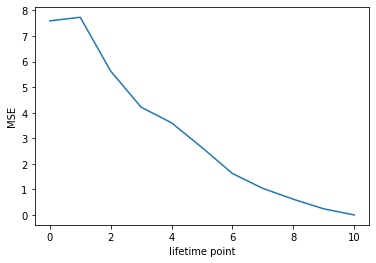

In [32]:
plt.plot(MSE)
plt.xlabel("lifetime point")
plt.ylabel("MSE")